In [4]:
import numpy as np;
import matplotlib as mpl;

Freeze-out: particles will stay in thermal equilibrium with the universe as long as the reactions keeping them in chemical equilibrium are proceeding at a rate higher than the expansion of the universe. If the expansion rate is faster than the reaction rate, the partices can no longer stay in equilibrium with the universe; they are 'frozen out'.

Hubble constant formula as a fn of freeze-out temperature:
H(Tfo) = Gamma(Tfo) = v(Tfo)*n(Tfo)*sigma(Tfo)

$Y = n/S$

$n \propto a^-3$

$S \propto a^-3$

We want to plot Y.

$\Omega = \frac{m n_{DM}}{\rho_c}$

### $T_{fo} \propto \frac{1}{M_{Pl} \sigma c}$

## TODO:
Write functions to calculate the Hubble constant (DONE) and g_{*S} as a function of temperature.
[Plot H] for cold dark matter (T_fo << m).

#### optional:
Use the equipartition theorem to find the velocity of cold DM (currently approximated as c)

## done:
Write functions to calculate the equilibrium number density of particles as a function of temperature (for the relativistic and non-relativistic cases).

Plot the present-day abundance (Omega) of hot dark matter (where T_fo >> m) for different masses and cross sections. How does it scale with these variables?

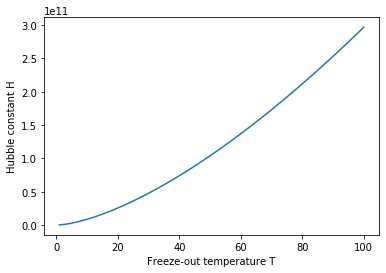

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import math

#plot Hubble constant at various temperatures
T_vect = np.linspace(1,100);
H_vect = [];
m = 1;
sigma = 1;
for T in T_vect:
    H_vect.append(H_cold(T,m,sigma));
plt.plot(T_vect,H_vect);
plt.xlabel("Freeze-out temperature T");
plt.ylabel("Hubble constant H");
plt.show();

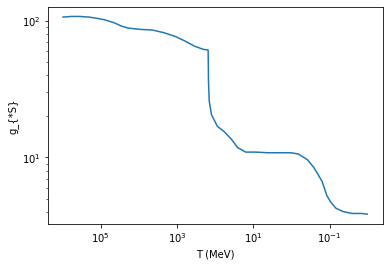

In [21]:
#extract gstar from data
gstar_data = np.genfromtxt('gstar.csv', delimiter=',')
plt.plot(gstar_data[:,0],gstar_data[:,1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('g_{*S}')
plt.xlabel('T (MeV)')
plt.gca().invert_xaxis()
plt.show()

def gstar(T):
    return np.interp(T,gstar_data[:,0], gstar_data[:,1])

In [17]:
from scipy.optimize import fsolve

T_0 = 0.235*10**(-3)
def T_to_a(T):
    return (gstar(T_0)/gstar(T))**(1/3)*(T_0/T)
def a_to_T(a):
    func = lambda T: a**3*(gstar(T))*T**3-gstar(T_0)*T_0**3
    T_initial_guess = gstar(T_0)**(1/3)*(T_0/a)
    T_solution = fsolve(func, T_initial_guess)
    return T_solution[0]

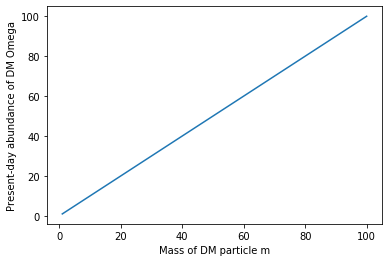

In [4]:
#calculate present-day abundance of DM as a function of m
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

M_pl = 1
critical_density = 1
T_fo = 1
m_vect = np.linspace(1,100)
c = 1
sigma = 1
G_F = 1
crit_density = 1
a = 1

#rough approximations of H, n, and sigma. Replace freely
def H(T):
    return (T**2)/M_pl

def n(T):
    return T**3

#average velocity of DM. Default = hot DM.
def v(T,rel=True):
    if rel == True:
        return c
    else:
        return 1;

#cross-section of DM self-interaction. The parameter alpha can be varied for ease of
#plotting different values of sigma
def sigma(T,alpha=1):
    return alpha*(G_F**2)*(T**2)
    
#solve for freeze-out temperature T_fo
def T_fo_solver(rel=True):
    def composite(T):
        return H(T) - (n(T)*v(T,rel)*sigma(T,alpha))
    return scipy.optimize.root_scalar(composite,bracket=[1,100],x0=10)

#present-day abundance of dark matter
def Omega(T,m,alpha):
    return dm_density(T,m)/crit_density

#dark matter density TODAY. n is the DM density at the decoupling, which needs
#to be multiplied by a scaling factor a^-3 accounting for expansion
def dm_density(T,m):
        return m*n(T)*a**(-3)

#plot Omega as a fn of m with constant sigma
m_vect = np.linspace(1,100)
alpha = 1
Omega_vect = []
for m in m_vect:
    Omega_vect.append(Omega(T_fo_solver().root,m,alpha))

plt.plot(m_vect,Omega_vect)
plt.xlabel("Mass of DM particle m")
plt.ylabel("Present-day abundance of DM Omega")
plt.show()

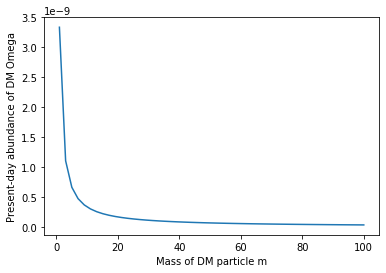

In [92]:
#calculate present-day abundance of DM as a fn of sigma

M_pl = 1;
critical_density = 1;
T_fo = 1;
sigma_vect = np.linspace(1,100);
m = 1;

#rough approximation
def H_hot(T):
    return (T**2)/M_pl

def n_hot(T,sigma):
    return H_hot(T)/(c*sigma);

def DM_density(T,m,sigma):
    return m*n_hot(T,sigma);

def Omega(T,m,sigma):
    return DM_density(T,m,sigma)/critical_density;

Omega_vect = [];
for sigma in sigma_vect:
    Omega_vect.append(Omega(T_fo,m,sigma));
    
plt.plot(sigma_vect,Omega_vect);
plt.xlabel("Mass of DM particle m");
plt.ylabel("Present-day abundance of DM Omega")
plt.show();

# $g_{*S}$ extracted from plot

# Conversion between $a$ and $T$
$$a^3g_{*S}(T)T^3=\text{const}$$